In [1]:
import sys
sys.path.append('../')
import src.utils as utils
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
reload(utils)
import scipy.stats as stat

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
np.random.seed(2)

In [5]:
def payoff_two_derivatives(S, K, B, gamma):
    return np.maximum(S-K,0) - (S/B)**(2*gamma)*np.maximum(B**2/S-K,0)

In [6]:
def gamma_val(r,sigma):
    return 1/2 - r/(sigma**2)

In [7]:
r1 = 0.05
r2 = 0
sigma = 0.1
K = 1
B = 0.9
smin = 0.65
smax = 1.5
S = np.linspace(smin,smax,num = 100)

gamma1 = gamma_val(r1,sigma)
gamma2 = gamma_val(r2,sigma)

Payoff1 = payoff_two_derivatives(S, K, B, gamma1)
Payoff2 = payoff_two_derivatives(S, K, B, gamma2)

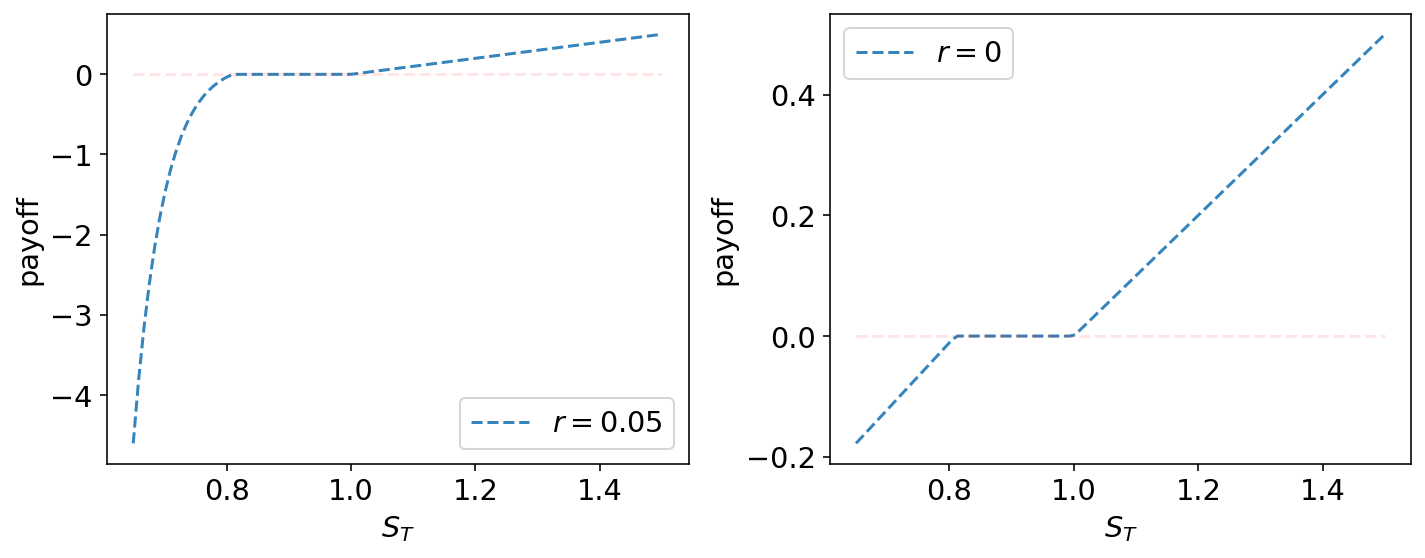

In [8]:
fig, ax = plt.subplots(1, 2, sharey=False, figsize=(10, 4))
fig.tight_layout(pad=3)

ax[0].plot(S, Payoff1, linestyle = '--', alpha = 0.9)
ax[0].hlines(y = 0, xmin = smin, xmax = smax, color = 'r', linestyles='--', alpha = 0.1)
ax[0].legend([f'$r = {r1}$'])


ax[1].plot(S, Payoff2, linestyle = '--', alpha = 0.9)
ax[1].hlines(y = 0, xmin = smin, xmax = smax, color = 'r', linestyles='--', alpha = 0.1)
ax[1].legend([f'$r = {r2}$'])

resolution_value = 50
ax[0].set_xlabel('$S_T$')
ax[1].set_xlabel('$S_T$')

ax[0].set_ylabel('payoff')
ax[1].set_ylabel('payoff')


plt.tight_layout()
plt.savefig('../figures/payoff_SSH_argument.pdf', format="pdf", dpi=resolution_value)
plt.show()

# A more general approach

In [9]:
def payoff_two_derivatives(S, K, B, gamma, f: callable):
    return f(S) - (S/B)**(2*gamma)*f(B**2/S)

In [10]:
def f_func(s):
    return s>B

In [11]:
Payoff1 = payoff_two_derivatives(S, K, B, gamma1, f_func)
Payoff2 = payoff_two_derivatives(S, K, B, gamma2, f_func)

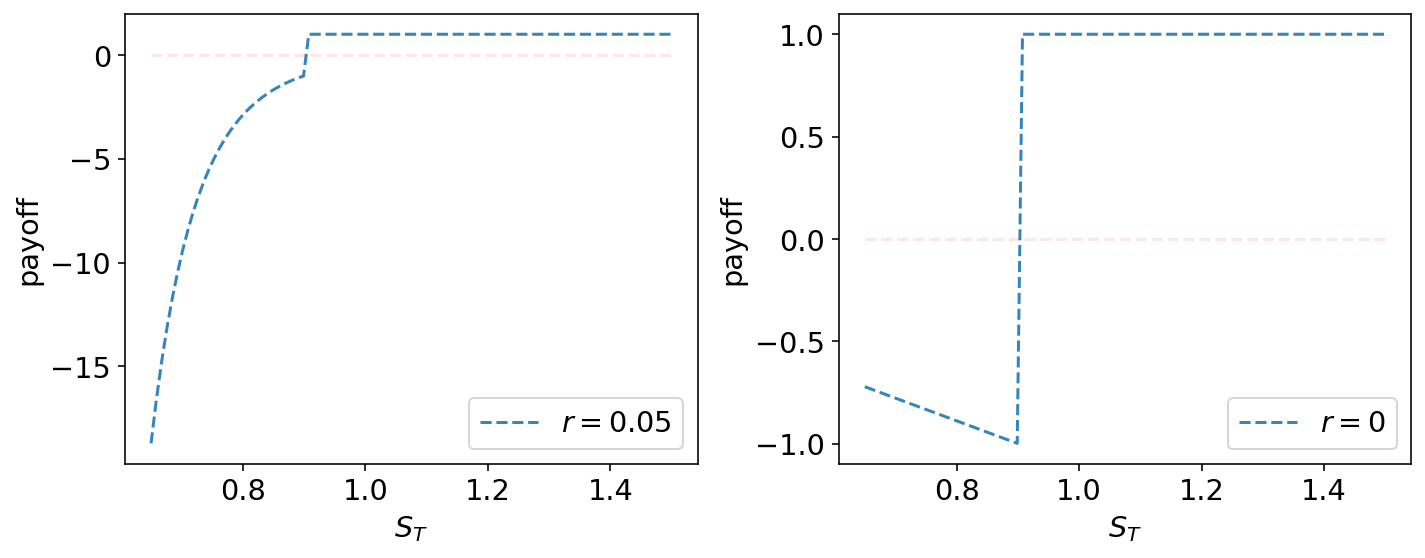

In [12]:
fig, ax = plt.subplots(1, 2, sharey=False, figsize=(10, 4))
fig.tight_layout(pad=3)

ax[0].plot(S, Payoff1, linestyle = '--', alpha = 0.9)
ax[0].hlines(y = 0, xmin = smin, xmax = smax, color = 'r', linestyles='--', alpha = 0.1)
ax[0].legend([f'$r = {r1}$'])


ax[1].plot(S, Payoff2, linestyle = '--', alpha = 0.9)
ax[1].hlines(y = 0, xmin = smin, xmax = smax, color = 'r', linestyles='--', alpha = 0.1)
ax[1].legend([f'$r = {r2}$'])

resolution_value = 50
ax[0].set_xlabel('$S_T$')
ax[1].set_xlabel('$S_T$')

ax[0].set_ylabel('payoff')
ax[1].set_ylabel('payoff')


plt.tight_layout()
plt.savefig('../figures/payoff_SSH_argument_no_touch.pdf', format="pdf", dpi=resolution_value)
plt.show()

# Comparing 'pricing with simulations' and the 'SSH argument'

In [13]:
t = 0
T = 1
S = 100
r = 0.03
sigma = 0.1
K = 100
B = 90
nsims = 1_000_000

### Pricing with simulation approach:
###### Simulate many trajectories under $\mathbb{Q}$, compute the payoff of each, average, and discount to the present

In [14]:
def call_option_payoff(K, S):
    return np.maximum(S-K,0)

In [15]:
GBM = utils.GeometricBrownianMotion(x0 = S, mu = r, sigma = sigma, T = T, Nt = 100)
paths = GBM.simulate(nsims = nsims)
payoff = call_option_payoff(K, paths[-1,:]) * (np.min(paths,axis = 0) > B)
approximation = np.exp(-r*(T-t))*np.sum(payoff)/nsims 

### Pricing with SSH and using simulations to approximate the solution:
###### Simulate many values of $S_T$ under $\mathbb{Q}$, compute the payoff of the SSH argument, average, and discount to the present

In [16]:
def simulate_S_T_under_Q(t,T,S,r,sigma,nsims):
    Z = np.random.randn(nsims,1)
    exponent = (r-0.5*sigma**2)*(T-t) + sigma*np.sqrt(T-t)*Z
    return S*np.exp(exponent)

In [17]:
def f_func(s):
    return  np.maximum(s-K,0)

In [18]:
S_T = simulate_S_T_under_Q(t,T,S,r,sigma,nsims)

In [19]:
gamma = gamma_val(r, sigma)
Payoff = payoff_two_derivatives(S_T, K, B, gamma, f_func)
approximation2 = np.exp(-r*(T-t)) * np.sum(Payoff)/nsims

In [22]:
print(f'Approximation 1 is {np.round(approximation,3)}')
print(f'Approximation 2 is {np.round(approximation2,3)}')

Approximation 1 is 5.537
Approximation 2 is 5.5
